# Depicting How Neural Networks Learn

I was inspired by the first chapter of a newly published book "Understanding Deep Learning" by Simon J.D. Prince. This notebook presents visualizations of how a simple neural network learns the functional form of a 3rd order polynomial toy dataset.

The core of this notebook is the visualizations after the training, which I will explain in more detail below.

DO: add the vertical lines

In [111]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [150]:
# Create third-order polynomial toy data
n = 750
x = np.linspace(-20, 20, n)
y  = x**3 + x**2 + x + np.random.normal(0, 750, size=n)

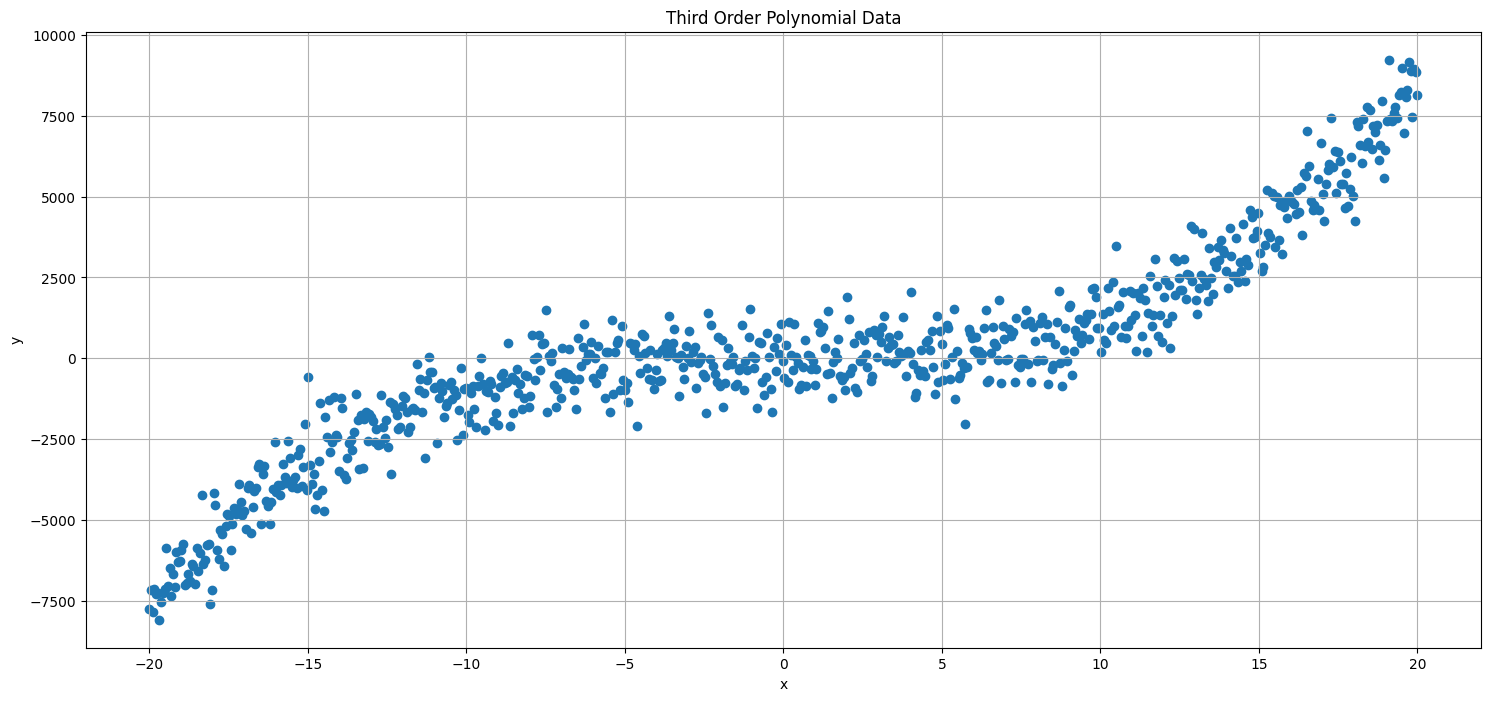

In [151]:
# Plot data
plt.figure(figsize=(18, 8))
plt.scatter(x, y)
plt.title('Third Order Polynomial Data')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [152]:
# Convert data to tensors
x = torch.tensor(x, dtype=torch.float32).view(-1,1)
y = torch.tensor(y, dtype=torch.float32).view(-1,1)

In [153]:
# Define NN
class MLP(nn.Module):
  def __init__(self):
      super(MLP, self).__init__()
      # Single hidden layer
      self.w1 = torch.randn(1, 6, requires_grad=True, generator=g)
      self.b1 = torch.randn(1, 6, requires_grad=True, generator=g)

      # Output layer
      self.w2 = torch.randn(6, 1, requires_grad=True, generator=g)
      self.b2 = torch.randn(1, 1, requires_grad=True, generator=g)

  def forward(self, x):
    z1 = x @ self.w1 + self.b1 # (B, 1) x (1, 6) + (1, 6) => (B, 6)
    a1 = F.relu(z1)
    z2 = a1 @ self.w2 + self.b2 # (B, 6) x (6, 1) + (1, 1) => (B, 1)
    return z2

  def getParams(self):
    '''Function to return params'''
    return [self.w1, self.b1, self.b2, self.w2]

  def getz1(self, x):
    '''Function to return pre-activations of hidden layer'''
    z1 = x @ self.w1 + self.b1
    return z1

  def geta1(self, x):
    '''Function to return activations of hidden layer'''
    z1 = x @ self.w1 + self.b1
    a1 = F.relu(z1)
    return a1


In [168]:
# Set seed and HPs
g = torch.Generator().manual_seed(1) #111
epoch = 15000
learning_rate = 0.00001

# Create model
model = MLP()
params = model.getParams()

In [169]:
# Function to visualise hidden layer outputs
def vis(x, y, datype='ypred', y2=None):

  y = y.detach().numpy()

  # For pre-activations and activations
  if datype != 'ypred':

    fig, axes = plt.subplots(1, 6, figsize=(18, 2))

    # Flatten axes for easy iteration
    axes_flat = axes.flatten()

    for i in range(y.shape[1]):
        axes_flat[i].plot(x, y[:, i])
        axes_flat[i].set_title(f'{datype} {i+1}')
        axes_flat[i].set_xlabel('x')
        axes_flat[i].set_ylabel('Values')
        axes_flat[i].grid(True)

    plt.tight_layout()

  # For y predictions
  else:
      fig = plt.figure(figsize=(18, 4))
      plt.plot(x, y.tolist(), color='red')
      plt.scatter(x, y2, color='blue', alpha=.2)  # Plot noisy data
      plt.title('Prediction')
      plt.xlabel('x')
      plt.ylabel('y_pred')
      plt.grid(True)
      plt.tight_layout()

  return fig

In [170]:
# Training loop
lossi = []
plota1, plotz1, plotypred = [], [], []

for e in range(epoch):
    # Set params to 0
    for p in params:
        p.grad=None

    # Feed data
    ypred = model(x)

    # Get and collect loss
    loss = F.mse_loss(ypred, y)
    lossi.append(loss.item())

    # Backprop
    loss.backward()

    # Update params
    for p in params:
        p.data += -learning_rate * p.grad

    # Show and save plots of loss
    if e % 1000 == 0:
      print(f'Epoch: {e} | Loss: {loss.item():.4f}')

      a1 = model.geta1(x)
      z1 = model.getz1(x)
      plota1.append(vis(x, z1, "Pre-activation"))
      plotz1.append(vis(x, a1, "ReLu Activations"))
      plotypred.append(vis(x, ypred, 'ypred', y))
      plt.close('all')

Epoch: 0 | Loss: 10220359.0000
Epoch: 1000 | Loss: 1016880.3125
Epoch: 2000 | Loss: 1143519.6250
Epoch: 3000 | Loss: 910794.4375
Epoch: 4000 | Loss: 818360.0625
Epoch: 5000 | Loss: 762553.0625
Epoch: 6000 | Loss: 717887.7500
Epoch: 7000 | Loss: 704148.7500
Epoch: 8000 | Loss: 679503.7500
Epoch: 9000 | Loss: 667557.6875
Epoch: 10000 | Loss: 663738.7500
Epoch: 11000 | Loss: 652076.4375
Epoch: 12000 | Loss: 639895.6250
Epoch: 13000 | Loss: 665526.0000
Epoch: 14000 | Loss: 632245.1250


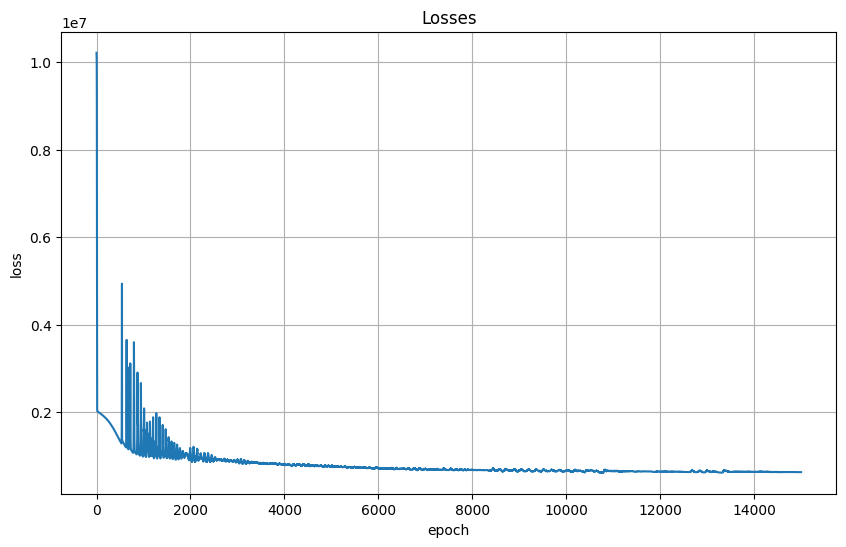

In [173]:
# Show losses over epoch
plt.figure(figsize=(10, 6))
plt.plot(range(epoch), lossi)
plt.title('Losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.show()

In [171]:
# Show plots
for i in range(len(plota1)):
  print(f"\n\n-------- Iteration {i*1000} --------\n\n")
  display(plota1[i])
  display(plotz1[i])
  display(plotypred[i])

Output hidden; open in https://colab.research.google.com to view.

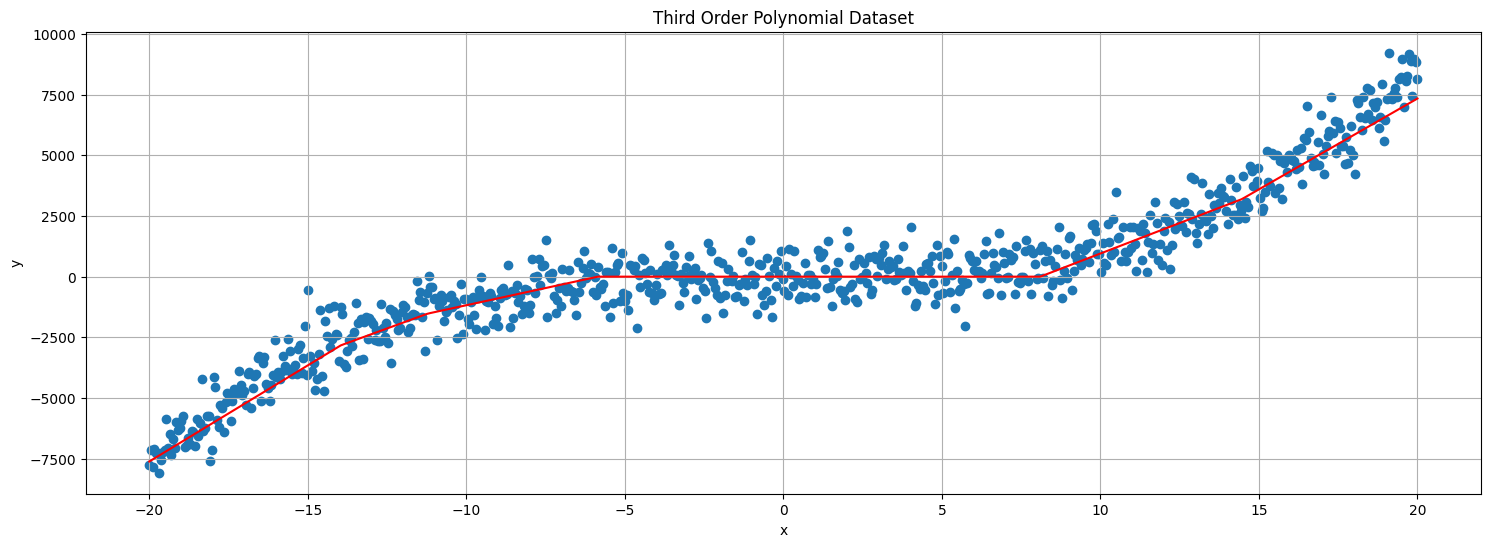

In [175]:
# Final plot of data and the MLP's learned function
plt.figure(figsize=(18, 6))
plt.scatter(x, y)
plt.plot(x, ypred.tolist(), color='red')
plt.title('Third Order Polynomial Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()